In [23]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import odeint

In [6]:
datos = np.genfromtxt('Datos.txt')


In [59]:
def model(q, t, sigma,rho,beta):
    x, y, z = q
    ecdiff = [sigma*(y - x), x*(rho - z), x*y - beta*z]
    return ecdiff

In [60]:
Initial_cond = datos[0,1:] #tiempo=0
q_obs = datos[:,1:] #posiciones que se tienen
tiempo= datos[:,0]

In [87]:
sigma = 2
rho = 1
beta = 1

In [88]:
sol = odeint(model, Initial_cond, tiempo, args=(sigma,rho,beta))

In [89]:
x,y,z=sol[:,0],sol[:,1],sol[:,2]

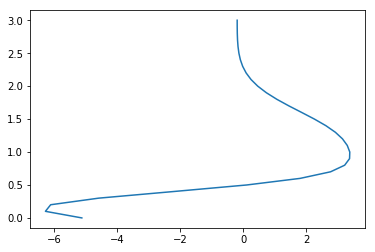

In [90]:
plt.plot(sol[:,1],tiempo)

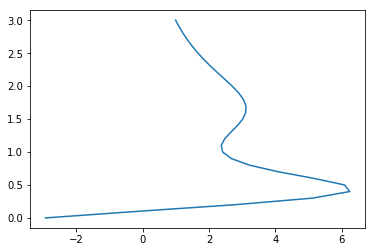

In [91]:
plt.plot(sol[:,2],tiempo)

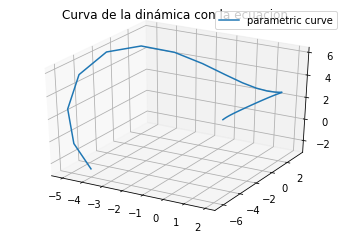

In [94]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z, label='parametric curve')
ax.legend()
ax.set_title("Curva de la dinámica con la ecuacion")
plt.show()

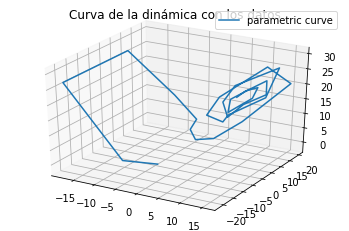

In [95]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(datos[:,1], datos[:,2], datos[:,3], label='parametric curve')
ax.legend()
ax.set_title("Curva de la dinámica con los datos")
plt.show()

In [96]:
def modelo_sol(initial,t,a,b,c):
    sol = odeint(model, initial, t, args=(a,b,c))
    return sol

In [102]:
def loglikelihood(initial,q_obs,t, a,b,c):
    """Logaritmo natural de la verosimilitud construida con los datos observacionales y los 
        parametros que describen el modelo.
    """
    d = q_obs -  model_sol(q,t,initial,a,b,c)
    d = d/1.0
    d = -0.5 * np.sum(d**2)
    norm= len(q_ob)/2.0*(np.log(2.0*np.pi))
    return d-norm
def logprior(a, b,c):
    """Logaritmo natural de los prior para los parametros.
        Todos corresponden a gaussianas con sigma=1.0.
    """
    d = -0.5 * (m**2/(1.0)**2 + b**2/(1.0)**2 + c**2/(1.0)**2)
    return d

In [99]:
def divergence_loglikelihood(initial,q_obs, t, a,b,c):
    """Divergencia del logaritmo de la funcion de verosimilitud.
    """
    n_param = 3
    div = np.ones(n_param)
    delta = 1E-5
    for i in range(n_param):
        div[i] = loglikelihood(initial, q_obs, t, a + delta,b+ delta,c+ delta) 
        div[i] = div[i] - loglikelihood(initial, q_obs, t, a - delta,b- delta,c- delta)
        div[i] = div[i]/(2.0 * delta)
    return div

In [100]:
def hamiltonian(initial,q_obs,t ,a,b,c, param_momentum):
    """Hamiltoniano: energia cinetica + potencial: K+V
    """
    m = 100.0
    K = 0.5 * np.sum(param_momentum**2)/m
    V = -loglikelihood(initial,q_obs,t, a,b,c) 
    return K + V

In [103]:
def leapfrog_proposal(initial, q_obs, t, a,b,c, param_momentum):
    """Integracion tipo leapfrog. 
        `param` representa las posiciones (i.e. los parametros).
        `param_momemtum` representa el momentum asociado a los parametros.
    """
    N_steps = 5
    delta_t = 1E-2
    m = 1.0
    new_param = param.copy()
    new_param_momentum = param_momentum.copy()
    for i in range(N_steps):
        new_param_momentum = new_param_momentum + divergence_loglikelihood(initial,q_obs, t, a,b,c) * 0.5 * delta_t
        new_a += new_param_momentum[0]*delta_t/mass
        new_b += new_param_momentum[1]*delta_t/mass
        new_c += new_param_momentum[2]*delta_t/mass
        new_param = new_param + (new_param_momentum/m) * delta_t
        new_param_momentum = new_param_momentum + divergence_loglikelihood(initial,q_obs, t, a,b,c) * 0.5 * delta_t
    new_param_momentum = -new_param_momentum
    return new_a, new_b,new_c, new_param_momentum

In [ ]:
def monte_carlo(q_obs, t, N=5000):
    a=[np.random.random()]
    b=[np.random.random()]
    c=[np.random.random()]
    initial=datos[0,1:]
    param_momentum = [np.random.normal(size=3)]
    logposterior = [loglikelihood(initial,q_obs,t, a,b,c)+ logprior(a[0], b[0],c[0])]
    for i in range(1,N):
        propuesta_a,propuesta_b,propuesta_c propuesta_param_momentum = leapfrog_proposal(initial, q_obs, t, a[i-1],b[i-1],c[i-1], param_momentum[i-1])
        energy_new = hamiltonian(initial,q_obs,t,propuesta_a,propuesta_b,propuesta_c, propuesta_param_momentum)
        energy_old = hamiltonian(initial,q_obs,t, a[i-1],b[i-1],c[i-1], param_momentum[i-1])
        initial,q_obs,t ,a,b,c, param_momentum
        logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_y_obs, m[i-1], b[i-1]) + logprior(m[i-1], b[i-1])
        logposterior_nuevo = loglikelihood(x_obs, y_obs, sigma_y_obs, propuesta_m, propuesta_b) + logprior(propuesta_m, propuesta_b)

        r = min(1,np.exp(-(energy_new - energy_old)))
        alpha = np.random.random()
        if(alpha<r):
            m.append(propuesta_m)
            b.append(propuesta_b)
            logposterior.append(logposterior_nuevo)
            
        else:
            m.append(m[i-1])
            b.append(b[i-1])
            logposterior.append(logposterior_viejo)
        param_momentum.append(np.random.normal(size=2))    

    m = np.array(m)    
    b = np.array(b)
    logposterior = np.array(logposterior)
    return m,b, logposterior